<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, Embedding, TimeDistributed
from keras.initializers import RandomNormal
# from keras.layers import Conv1D, MaxPooling2D
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
np.random.seed(1)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

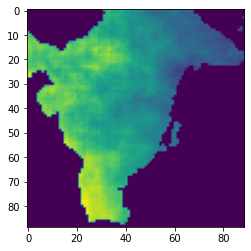

In [4]:
pickle_in = open("/content/drive/MyDrive/Preprosessing_data/rainfall_flatten.pickle","rb")
# data diload sudah dalam bentuk 1D
X = pickle.load(pickle_in)
# untuk menampilkan gambar data 1D -> 2D
plt.imshow(X[-60].reshape(89,89))

In [ ]:

# X = read_csv('/content/drive/MyDrive/Preprosessing_data/Rainfall_full_wo_index.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [ ]:
len(X)

480

In [ ]:
np.array(X).shape

(480, 7921)

In [5]:
df = X
data_1 = df[:-48]
# data_2 = df[:-36]
# data_3 = df[:-24]
data_4 = df[:-12]
# data_5 = df
# # data tahun 1981-2015
# # df=df[:-60]

In [ ]:
len(data_1)/12

36.0

In [ ]:
# np.array(data_4).shape[0]/12

In [ ]:
# # train -> data 1981-2015
# train, test = df, df[-24:]

In [6]:
train, test = df[:-24], df[-24:]
# len(train)

In [ ]:
len(train)/12

38.0

In [ ]:
np.array(train).shape[0]/12

In [ ]:
np.array(test).shape[0]/12

In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
scaler.fit(data_4)
scaler.fit(test)
train = scaler.transform(train)
data_4 = scaler.transform(data_4)
test = scaler.transform(test)

In [ ]:
len(train)/12

In [8]:
n_input = 12
n_features = 7921
batch_size = 12
# supervised data
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=batch_size)
validation_sequence = TimeseriesGenerator(test,test, length=n_input, batch_size=batch_size)

In [9]:
from keras.layers import *
from keras.models import *
from keras import backend as K

In [10]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
# def build(self, input_shape):
#         self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
#                                initializer="normal")
#         self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
#                                initializer="zeros")

In [ ]:
# def call(self, x):
#         e = K.tanh(K.dot(x,self.W)+self.b)
#         a = K.softmax(e, axis=1)
#         output = x*a

In [ ]:
len(generator)

In [11]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from tensorflow import keras
model = Sequential()
model.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(400, return_sequences=True))
model.add(LSTM(500, return_sequences=True))
# model.add(LSTM(228, return_sequences=True))
# model.add(LSTM(228, return_sequences=True))
# model.add(LSTM(228, return_sequences=True))
# model.add(Bidirectional(LSTM(228, input_shape=(n_input, n_features), return_sequences=True)))
model.add(attention(return_sequences=False)) # receive 3D and output 3D
# model.add(Dropout(0.2))
# model.add(LSTM(228, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1), unit_forget_bias='zeros', return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(228, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
# model.add(Dropout(0.2))
# model.add(Dense(60, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
# model.add(Dropout(0.2))
# model.add(Dense(n_features, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
# model.add(Dropout(0.2))
model.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 228)           7432800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 300)           634800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 400)           1121600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 500)           1802000   
_________________________________________________________________
attention (attention)        (None, 500)               512       
_________________________________________________________________
dense (Dense)                (None, 7921)              3968421   
Total params: 14,960,133
Trainable params: 14,960,133
Non-trainable params: 0
____________________________________________

In [13]:
history = model.fit(generator, epochs=1000, validation_data=generator)

Epoch 1/1000
37/37 [==============================] - 7s 54ms/step - loss: 0.1229 - accuracy: 0.0000e+00 - val_loss: 0.1073 - val_accuracy: 0.0023
Epoch 2/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1057 - accuracy: 0.0023 - val_loss: 0.1039 - val_accuracy: 0.0203
Epoch 3/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1044 - accuracy: 0.0113 - val_loss: 0.1101 - val_accuracy: 0.0203
Epoch 4/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1041 - accuracy: 0.0045 - val_loss: 0.1045 - val_accuracy: 0.0045
Epoch 5/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1038 - accuracy: 0.0090 - val_loss: 0.1031 - val_accuracy: 0.0045
Epoch 6/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1044 - accuracy: 0.0158 - val_loss: 0.1038 - val_accuracy: 0.0203
Epoch 7/1000
37/37 [==============================] - 1s 24ms/step - loss: 0.1030 - accuracy: 0.0090 - val_loss: 0.1035 - val_accuracy: 0.

In [15]:
# model.evaluate(validation_sequence)
# trainPredict = model.predict_generator(generator)
# testPredict = model.predict_generator(validation_sequence)
# print(a)
# print(trainPredict)
# print(testPredict)
# tt = model.predict(generator)
# print(tt)

# scores = model.evaluate_generator(validation_sequence,7921)
# print("Accuracy = ", scores[0],[1])

loss, acc = model.evaluate_generator(validation_sequence, verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate_generator(validation_sequence,verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.0000 
Loss on training data: 0.0294 

Accuracy on test data: 0.0000 
Loss on test data: 0.0294 



In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

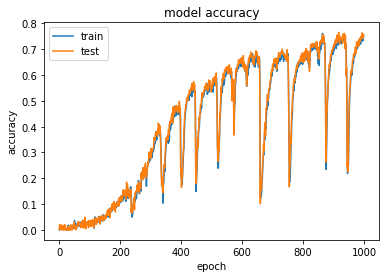

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

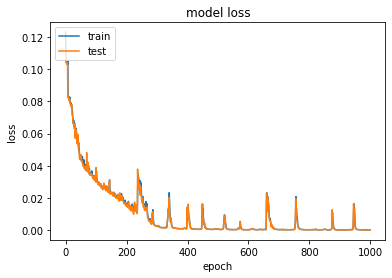

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
pred_list = []

batch = train[-12:].reshape((1, n_input, n_features))
batch

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

pred_list = scaler.inverse_transform(pred_list)

# prediksi = (model.predict(batch)[0])

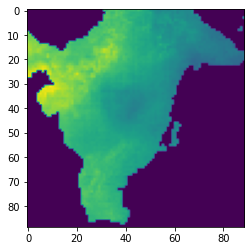

In [ ]:
plt.imshow(pred_list[0].reshape(89,89))

In [ ]:
# train = df
# test = df[-24:]

In [ ]:
# scaler.fit(train)
# train = scaler.transform(train)
# scaler.fit(test)
# test = scaler.transform(test)

In [ ]:
# n_input = 12
# n_features = 7921
# generator = TimeseriesGenerator(train, train, length=n_input, batch_size=12)
# validation_sequence = TimeseriesGenerator(test, test, length=n_input, batch_size=12)

In [ ]:
# model.fit_generator(generator,epochs=100, validation_data=generator)

In [ ]:
# model.evaluate_generator(validation_sequence)

[0.12503628432750702, 0.0]

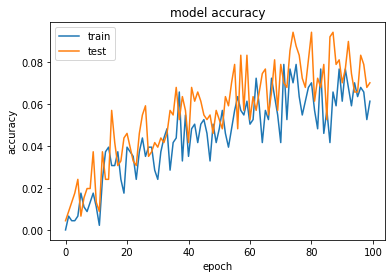

In [ ]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

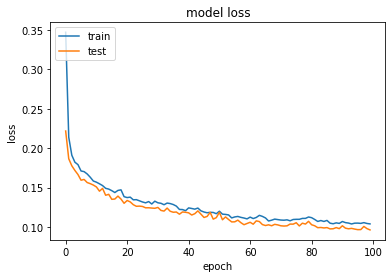

In [ ]:
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [19]:
pred_list = []

batch = data_4[-60:-48].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
    
batch1 = data_4[-48:-36].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch1)[0]) 
    batch1 = np.append(batch1[:,1:,:],[[pred_list[i]]],axis=1)
    
batch2 = data_4[-36:-24].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch2)[0]) 
    batch2 = np.append(batch2[:,1:,:],[[pred_list[i]]],axis=1)
    
# data tahun 2018 untuk memprediksi tahun 2019
batch3 = data_4[-24:-12].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch3)[0]) 
    batch3 = np.append(batch3[:,1:,:],[[pred_list[i]]],axis=1)

# data tahun 2019 untuk memprediksi tahun 2020
batch4 = data_4[-12:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch4)[0]) 
    batch4 = np.append(batch4[:,1:,:],[[pred_list[i]]],axis=1)

In [20]:
batch

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
pred_list = scaler.inverse_transform(pred_list)
pred_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
pred_list.shape

(60, 7921)

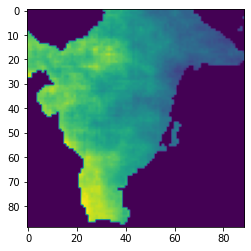

In [23]:
plt.imshow(pred_list[0].reshape(89,89))

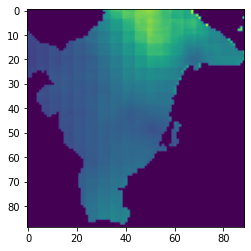

In [24]:
df_asli = data_1
plt.imshow(df_asli[0].reshape(89,89))

In [25]:
max(pred_list[10])

523.276365348429

In [26]:
max(df_asli[10])

581.58936

In [27]:
# MAE untuk semua data
pred_list[pred_list<0]=0
pred_list_new=[]
df_asli_new=[]
no=0
df_asli=np.array(df_asli)
# for pred in pred_list:
#     pred_list_new.append(list(filter(lambda x: x != 0, pred_list[no])))
#     df_asli_new.append(list(filter(lambda x: x != 0, df_asli[no])))
#     no+=1
    
pred_list_new=np.array(pred_list_new)
df_asli_new=np.array(df_asli_new)

# pred_list.shape
# np.array(df_asli_new).shape

mae=[]
no=0
# for pred1 in pred_list:
#     mae_ = df_asli[no]-pred1
#     mae_ = np.average(mae_)
#     mae.append(mae_)
#     no+=1
from sklearn.metrics import mean_absolute_error
for pred1 in pred_list:
    mae_ = mean_absolute_error(df_asli[no], pred1)
    mae.append(mae_)
    no+=1

In [28]:
mae

[56.133265982723394,
 45.25683358478354,
 33.70067383053723,
 56.9094918010083,
 24.745073786131364,
 31.921240754545007,
 18.864531171579642,
 56.773364427253185,
 41.376272487875866,
 54.532364023643716,
 16.69477463290316,
 33.8822995410555,
 53.94101362082248,
 36.0417092678726,
 20.717186649077668,
 31.514696904363632,
 55.97585742861149,
 40.64197503315092,
 97.81163064018477,
 49.8179940818104,
 35.18105015857053,
 43.444338735722326,
 55.356649083808364,
 46.721432063540874,
 55.37396239472899,
 83.77128938094113,
 127.21240801981433,
 28.322507781100086,
 78.07950717790901,
 37.33982901911044,
 28.96105802940109,
 29.66166315011477,
 18.28994291743437,
 22.371476277681985,
 43.80146252369307,
 30.108065292340857,
 56.1140107418703,
 19.178000337000764,
 66.16669958090331,
 24.030541950556007,
 27.777321442324304,
 29.873365892244465,
 28.15807673015159,
 32.66911216367925,
 41.31947006106574,
 20.873876280797116,
 28.65690798829087,
 33.054583804573234,
 51.17866948979664,
 14

In [29]:
# pred_list_new

Pred_rata= []
for i in range(0,60):
	Pred_rata.append((pred_list[i].mean()))


In [30]:
df_asli_rata= []
for i in range(0,60):
	df_asli_rata.append((df_asli[i].mean()))

In [31]:
Pred_rata

[117.71806713642556,
 90.55461283978083,
 112.11924044261526,
 89.27118420679776,
 115.7848108063276,
 111.15654892330315,
 108.21338914825454,
 91.23178183606957,
 142.0106828588766,
 160.43304198089785,
 146.224802328759,
 173.73808950195928,
 106.19976807527621,
 124.63082996414767,
 138.6907277053259,
 171.83893933178328,
 157.95537054811874,
 120.9294536867346,
 129.6831111444301,
 89.3177173401756,
 94.05655439606284,
 80.15286161794681,
 128.74134394968712,
 151.73074854302087,
 124.97995196215648,
 132.85965767601425,
 163.15187885659677,
 150.4969939210416,
 144.5159902426414,
 93.96207802668246,
 108.32781859023189,
 113.60415221606297,
 81.94921524906601,
 92.75054519505616,
 130.8420888023962,
 152.22251617085524,
 122.32816522038138,
 131.05018510082851,
 120.3616141054436,
 144.40734056287587,
 150.77108102491164,
 82.29557875429379,
 103.89351004279331,
 90.60267256900968,
 80.97757505450333,
 90.95224211206745,
 130.84242542551985,
 152.22251616680452,
 105.431091995962

In [32]:
df_asli_rata


[119.93916,
 133.88625,
 87.742004,
 145.74023,
 111.5375,
 133.01057,
 111.06511,
 34.458416,
 104.46941,
 106.402336,
 144.94788,
 176.31464,
 160.01277,
 156.70775,
 133.62082,
 174.71295,
 113.59026,
 81.2385,
 31.87148,
 39.52772,
 58.95609,
 36.77,
 74.294136,
 106.14285,
 69.61896,
 49.088367,
 35.939472,
 130.35999,
 67.810074,
 123.91537,
 85.43976,
 131.51279,
 93.266174,
 99.86078,
 168.96759,
 139.85815,
 172.37337,
 143.28828,
 186.30042,
 152.04697,
 174.9199,
 102.17321,
 80.59309,
 121.445526,
 121.29715,
 86.886154,
 126.59304,
 123.7248,
 155.6448,
 100.175606,
 163.86098,
 202.7655,
 130.84483,
 68.08208,
 126.70742,
 128.26695,
 109.86915,
 88.47699,
 159.24005,
 158.82715]

In [33]:
# membuat index tanggal, agar mempudah dalam proses plotting data
awal = "2016-1"
awal = pd.to_datetime(awal)
from pandas.tseries.offsets import DateOffset
add_dates = [awal + DateOffset(months=x) for x in range(0,60) ]
add_dates

[Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-

In [ ]:
len(add_dates)


In [ ]:
len(Pred_rata)


In [ ]:
len(df_asli_rata)

In [34]:
dict = {'bulan': add_dates, 'data ':mae}
df = pd.DataFrame(dict)

In [ ]:
df

,bulan,data
0,2016-01-01,62.858092
1,2016-02-01,75.239719
2,2016-03-01,22.331987
3,2016-04-01,59.283131
4,2016-05-01,26.830226
5,2016-06-01,48.223828
6,2016-07-01,29.848363
7,2016-08-01,53.672936
8,2016-09-01,19.528915
9,2016-10-01,29.441150


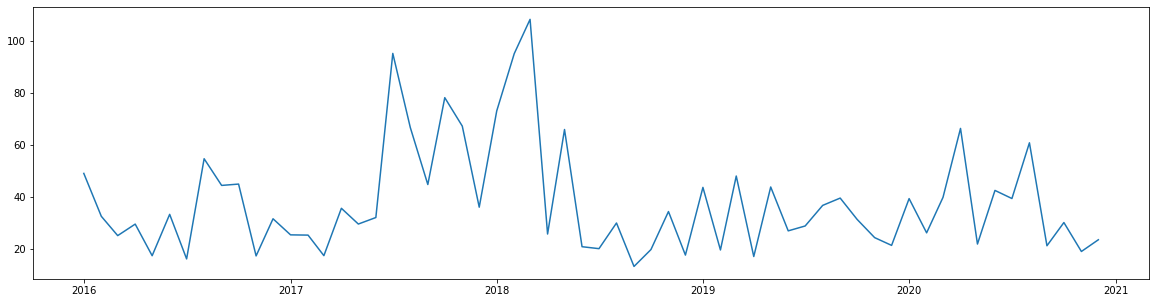

In [ ]:
df = df.set_index("bulan")
plt.figure(figsize=(20, 5))
plt.plot(df.index,df)

In [35]:
dict = {'bulan': add_dates, 'data prediksi':Pred_rata, 'data asli':df_asli_rata}
df = pd.DataFrame(dict)
df


,bulan,data prediksi,data asli
0,2016-01-01,117.718067,119.939163
1,2016-02-01,90.554613,133.886246
2,2016-03-01,112.119240,87.742004
3,2016-04-01,89.271184,145.740234
4,2016-05-01,115.784811,111.537498
5,2016-06-01,111.156549,133.010574
6,2016-07-01,108.213389,111.065109
7,2016-08-01,91.231782,34.458416
8,2016-09-01,142.010683,104.469414
9,2016-10-01,160.433042,106.402336


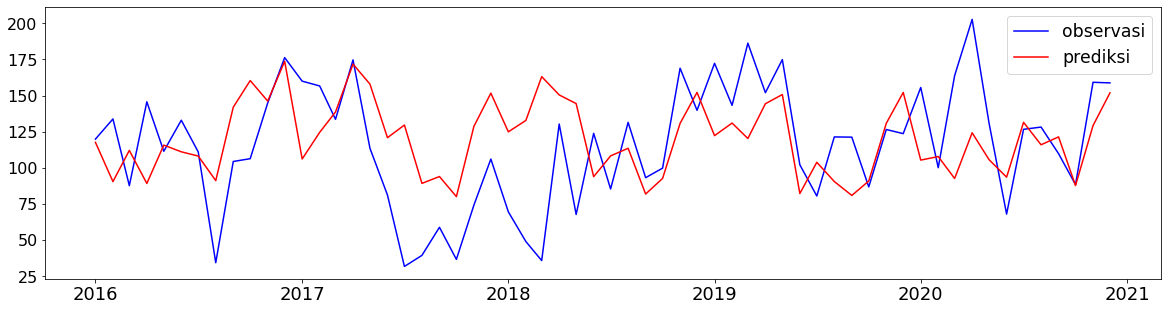

In [36]:
# df_asli = data_4
df = df.set_index("bulan")
plt.figure(figsize=(20, 5))
plt.plot(df.index, df_asli_rata[-60:], color='b', label="observasi")
plt.plot(df.index, Pred_rata[-60:], color='r', label="prediksi")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
# # Time series data

# data = mae

 

# # Plot autocorrelation

# plt.acorr(data, maxlags=12)

 

# # Add labels to autocorrelation plot

# plt.title('Autocorrelation of LSTM')

# plt.xlabel('Lag')

# plt.ylabel('Autocorrelation')

 

# # Display the autocorrelation plot

# plt.show()

import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(mae, lags=12 , alpha=0.05)
acf.show()

In [ ]:
pacf = smt.graphics.plot_pacf(mae, lags=12 , alpha=0.05)
pacf.show()

In [ ]:
plt.imshow((df_asli[59]-pred_list[59]).reshape(89,89))

In [ ]:
sum(mae)/60

In [ ]:
from skimage import io
# io.imsave('NewRaster/201201.tif', pred_list[0].reshape(83,114))

In [ ]:
pred_list[pred_list==0]=-9999

In [ ]:
model.save('LSTM102030DENSE405060_adam_seed1.h5')